In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy.stats import truncnorm
import matplotlib.pylab as pylab
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb

## Phân Tích

In [3]:
#tạo DataFrame với các cột đã được số hóa
df_raw = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/batdongsan/numerized/NhaO_numerized-dataset.csv',index_col=False)

In [4]:
df_raw = df_raw.drop(columns=['Lat','Long'])
df_raw = df_raw.dropna(subset=['City', 'District', 'Ward'])

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45236 entries, 0 to 45924
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DienTich      45235 non-null  float64
 1   DiaChi        45236 non-null  object 
 2   City          45236 non-null  float64
 3   District      45236 non-null  float64
 4   MucGia        40701 non-null  float64
 5   MatTien       28099 non-null  float64
 6   PhapLy        36939 non-null  float64
 7   DuongVao      21690 non-null  float64
 8   HuongNha      11482 non-null  float64
 9   SoTang        38288 non-null  float64
 10  SoPhongNgu    30790 non-null  float64
 11  SoToilet      28218 non-null  float64
 12  NoiThat       25163 non-null  float64
 13  HuongBanCong  6748 non-null   float64
 14  Ward          45236 non-null  float64
dtypes: float64(14), object(1)
memory usage: 5.5+ MB


In [6]:
#giới hạn các giá trị tập trung nhiều trong khoảng 25% - 75%

for variable in ['DienTich', 'MucGia', 'MatTien', 'DuongVao','SoTang','SoPhongNgu', 'SoToilet','HuongBanCong']:
    if df_raw[variable].dropna().empty:
        print(f"Column {variable} is empty or contains only NaN values.")
        continue
    Q1 = np.quantile(df_raw[variable].dropna(), 0.25)
    Q3 = np.quantile(df_raw[variable].dropna(), 0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_raw = df_raw[(df_raw[variable] >= lower_bound) & (df_raw[variable] <= upper_bound)]

In [7]:
df_raw.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,HuongBanCong,Ward
count,3075.000000,3075.000000,3075.000000,3.075000e+03,3075.000000,2916.000000,3075.000000,3056.000000,3075.000000,3075.000000,3075.000000,2415.000000,3075.000000,3075.000000
mean,79.352234,44.315447,457.249106,9.464229e+09,5.105824,1.222565,8.684472,4.914594,3.534634,3.814959,3.738211,1.961491,4.889106,16525.317073
std,39.791703,33.952290,311.245692,7.235643e+09,1.415799,0.767825,5.483298,2.159947,1.373021,1.303081,1.432300,0.949735,2.166852,11032.886742
min,10.000000,1.000000,1.000000,3.900000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,50.000000,1.000000,256.000000,4.600000e+09,4.000000,1.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,9190.000000
50%,72.000000,48.000000,494.000000,7.000000e+09,5.000000,1.000000,7.000000,5.000000,4.000000,4.000000,4.000000,2.000000,5.000000,20285.000000
75%,100.000000,79.000000,764.000000,1.200000e+10,6.000000,1.000000,12.000000,7.000000,5.000000,4.000000,5.000000,3.000000,7.000000,26882.000000
max,262.000000,95.000000,954.000000,4.200000e+10,9.000000,4.000000,24.000000,8.000000,8.000000,8.000000,8.000000,3.000000,8.000000,31825.000000


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3075 entries, 8 to 45918
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DienTich      3075 non-null   float64
 1   DiaChi        3075 non-null   object 
 2   City          3075 non-null   float64
 3   District      3075 non-null   float64
 4   MucGia        3075 non-null   float64
 5   MatTien       3075 non-null   float64
 6   PhapLy        2916 non-null   float64
 7   DuongVao      3075 non-null   float64
 8   HuongNha      3056 non-null   float64
 9   SoTang        3075 non-null   float64
 10  SoPhongNgu    3075 non-null   float64
 11  SoToilet      3075 non-null   float64
 12  NoiThat       2415 non-null   float64
 13  HuongBanCong  3075 non-null   float64
 14  Ward          3075 non-null   float64
dtypes: float64(14), object(1)
memory usage: 384.4+ KB


In [10]:
#thêm một cột LogPrice để so sánh với các cột khác. Giúp giá trị nhỏ lại để dễ trực quan
df_raw['LogPrice'] = np.log(df_raw['MucGia'])

#thêm cột USD để về sau xây dựng mô hình với giá USD hạn chế được sai số do VND quá lớn (tỉ giá đổi 25k / 1$)
df_raw['USD']=df_raw['MucGia'].astype(float)/25000

In [11]:
# Thiết kế biểu đồ
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

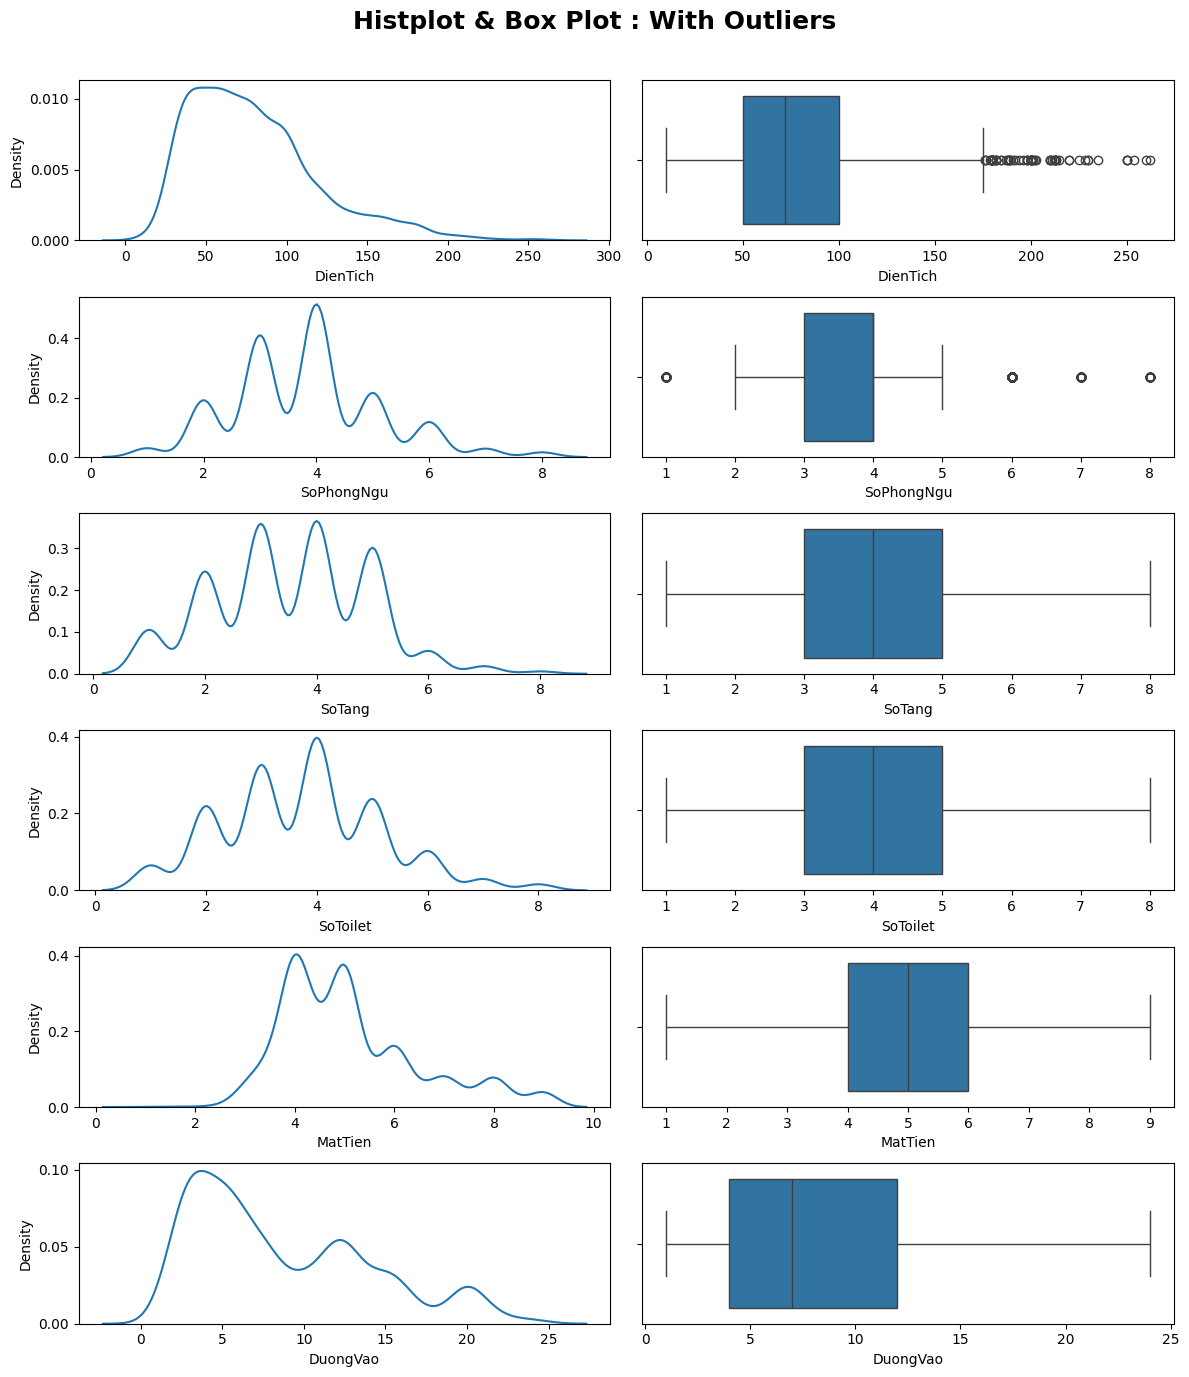

In [12]:
fig, ax = plt.subplots(6,2, figsize = (12,14))

fig.suptitle('Histplot & Box Plot : With Outliers', size = 18, fontweight="bold")
sns.kdeplot(ax= ax[0,0], data = df_raw, x = 'DienTich')
sns.boxplot(ax= ax[0,1], data = df_raw, x = 'DienTich')
sns.kdeplot(ax= ax[1,0], data = df_raw, x = 'SoPhongNgu')
sns.boxplot(ax= ax[1,1], data = df_raw, x = 'SoPhongNgu')
sns.kdeplot(ax= ax[2,0], data = df_raw, x = 'SoTang')
sns.boxplot(ax= ax[2,1], data = df_raw, x = 'SoTang')
sns.kdeplot(ax= ax[3,0], data = df_raw, x = 'SoToilet')
sns.boxplot(ax= ax[3,1], data = df_raw, x = 'SoToilet')
sns.kdeplot(ax= ax[4,0], data = df_raw, x = 'MatTien')
sns.boxplot(ax= ax[4,1], data = df_raw, x = 'MatTien')
sns.kdeplot(ax= ax[5,0], data = df_raw, x = 'DuongVao')
sns.boxplot(ax= ax[5,1], data = df_raw, x = 'DuongVao')


pylab.rcParams.update(rcParams)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

Cột DienTich vẫn còn nhiều dữ liệu ngoại lệ (outliers)

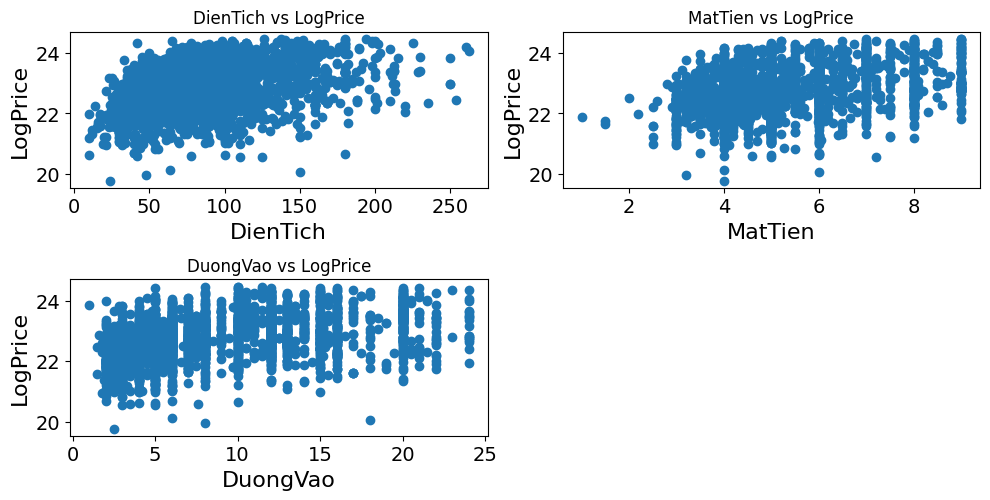

In [13]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(df_raw[x],df_raw['LogPrice'])
    plt.title(x+' vs LogPrice')
    plt.ylabel('LogPrice')
    plt.xlabel(x)


plt.figure(figsize=(10,12))


scatter('DienTich', 1)
scatter('MatTien', 2)
scatter('DuongVao', 3)
plt.tight_layout()

Diện tích, mặt tiền, đường vào có ảnh hưởng đến mức giá

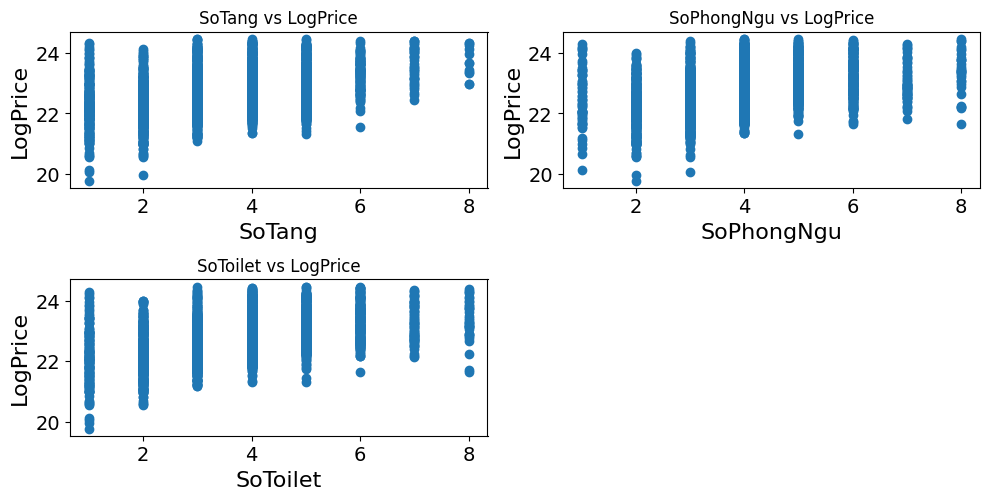

In [14]:
plt.figure(figsize=(10,12))

scatter('SoTang', 1)
scatter('SoPhongNgu', 2)
scatter('SoToilet', 3)

plt.tight_layout()

Số tầng, số phòng ngủ và số Toilet không ảnh hưởng đến mức giá

C:\Users\quanp\AppData\Local\Temp\ipykernel_5276\234935976.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['HuongBanCong'], y=df_raw['USD'], palette="plasma")


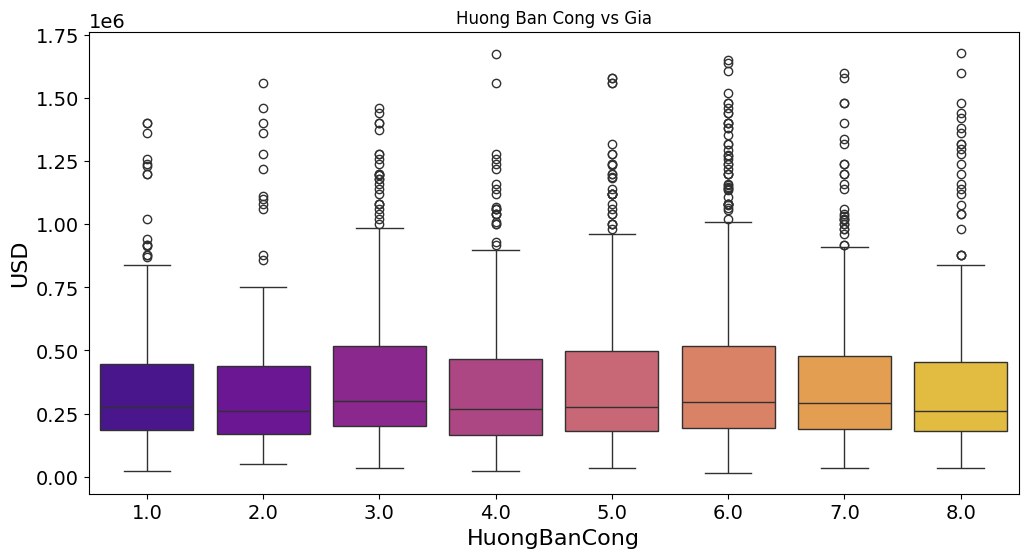

C:\Users\quanp\AppData\Local\Temp\ipykernel_5276\234935976.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")


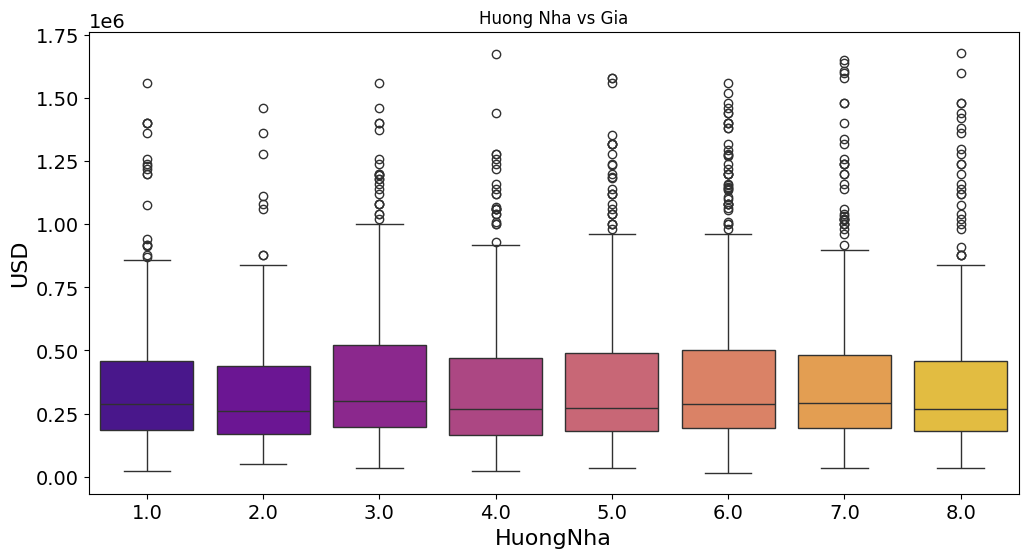

C:\Users\quanp\AppData\Local\Temp\ipykernel_5276\234935976.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")


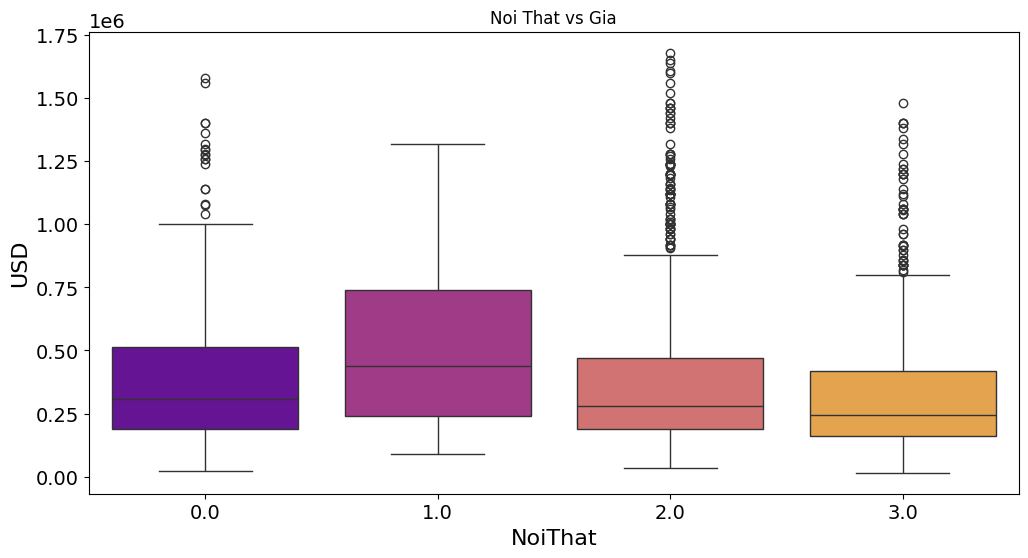

C:\Users\quanp\AppData\Local\Temp\ipykernel_5276\234935976.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")


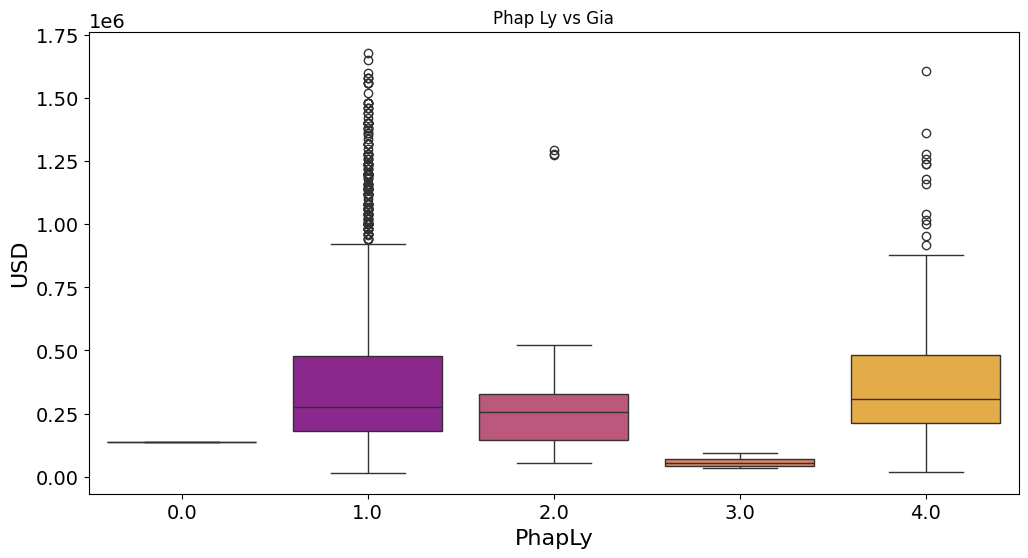

In [15]:
# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = (12, 6)

# Creating the box plots

sns.boxplot(x=df_raw['HuongBanCong'], y=df_raw['USD'], palette="plasma")
plt.title('Huong Ban Cong vs Gia')
plt.show()

sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")
plt.title('Huong Nha vs Gia')
plt.show()

sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")
plt.title('Noi That vs Gia')
plt.show()

sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")
plt.title('Phap Ly vs Gia')
plt.show()

Nội thất, pháp lý ảnh hưởng giá |||||| 
Hướng ban công, hướng nhà không ảnh hưởng nhiều

In [16]:
valid_cities = [
    'Hà Nội', 'Hồ Chí Minh', 'Đà Nẵng', 'Cần Thơ', 'Hải Phòng', 'Hạ Long', 'Nha Trang', 
    'Huế', 'Vũng Tàu', 'Biên Hòa', 'Quy Nhơn', 'Pleiku', 'Bình Dương', 'Bạc Liêu', 
    'Cà Mau', 'Sóc Trăng', 'Tây Ninh', 'Bến Tre', 'Long An', 'Tiền Giang', 'Trà Vinh', 
    'Hậu Giang', 'Đồng Tháp', 'An Giang', 'Kiên Giang', 'Vĩnh Long', 'Hà Tĩnh', 
    'Quảng Bình', 'Quảng Trị', 'Lâm Đồng', 'Đắk Lắk', 'Đắk Nông', 'Kon Tum', 'Gia Lai', 
    'Yên Bái', 'Thái Nguyên', 'Bắc Ninh', 'Bắc Giang', 'Hưng Yên', 'Hà Nam', 'Nam Định', 
    'Ninh Bình', 'Thanh Hóa', 'Nghệ An', 'Hòa Bình', 'Lào Cai', 'Tuyên Quang', 
    'Hà Giang', 'Cao Bằng', 'Lạng Sơn', 'Sơn La', 'Điện Biên', 'Hải Dương', 'Vĩnh Phúc', 
    'Hà Tây', 'Hưng Yên', 'Thái Bình', 'Hải Phòng', 'Bắc Kạn', 'Bắc Giang'
]

def extract_city(address):
    parts = address.split(',')
    for part in reversed(parts):
        part = part.strip().replace('.', '')
        if part in valid_cities:
            return part
    return None

# Tạo cột 'city' chứa tên thành phố
df_raw['ThanhPho'] = df_raw['DiaChi'].apply(extract_city)

df_raw.head()

,DienTich,DiaChi,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,HuongBanCong,Ward,LogPrice,USD,ThanhPho
8,117.9,"Đường Lộ Vòng Cung, Phường An Bình, Ninh Kiều,...",92.0,916.0,6.400000e+09,6.84,1.0,20.0,6.0,1.0,2.0,1.0,2.0,6.0,31150.0,22.579564,256000.0,Cần Thơ
12,58.0,"Đường Trương Định, Phường Trương Định, Hai Bà ...",1.0,7.0,6.790000e+09,4.00,1.0,3.0,1.0,5.0,3.0,4.0,NaN,1.0,298.0,22.638717,271600.0,Hà Nội
35,45.0,"Đường Nguyễn Văn Cừ, Phường Ngọc Lâm, Long Biê...",1.0,4.0,8.900000e+09,4.00,1.0,3.0,3.0,6.0,3.0,4.0,2.0,3.0,133.0,22.909317,356000.0,Hà Nội
80,75.0,"Đường Nguyễn Thị Định, Phường Trung Hòa, Cầu G...",1.0,5.0,3.150000e+10,6.00,1.0,12.0,3.0,7.0,8.0,7.0,NaN,3.0,175.0,24.173253,1260000.0,Hà Nội
89,95.0,"Dự án Nam Cầu Tuyên Sơn-Nam Việt Á, Đường Trịn...",48.0,494.0,5.700000e+09,5.00,1.0,7.5,5.0,2.0,2.0,2.0,2.0,5.0,20285.0,22.463732,228000.0,Đà Nẵng


In [17]:
district = df_raw['ThanhPho'].value_counts()
district.head(50)

ThanhPho
Hồ Chí Minh    1054
Hà Nội          986
Đà Nẵng         199
Hải Phòng       143
Nha Trang       128
Bình Dương       90
Hưng Yên         89
Bắc Ninh         77
Biên Hòa         48
Long An          21
Kiên Giang       19
Vũng Tàu         19
Cần Thơ          17
Hà Nam           16
Hạ Long          16
Thanh Hóa        15
Nghệ An           8
Lâm Đồng          7
Quy Nhơn          6
Lào Cai           5
An Giang          5
Huế               5
Tiền Giang        4
Bắc Giang         4
Hải Dương         3
Thái Nguyên       3
Nam Định          2
Tây Ninh          2
Cao Bằng          2
Thái Bình         2
Vĩnh Long         1
Hòa Bình          1
Quảng Trị         1
Lạng Sơn          1
Bến Tre           1
Đắk Lắk           1
Ninh Bình         1
Bạc Liêu          1
Hà Tĩnh           1
Gia Lai           1
Hà Giang          1
Name: count, dtype: int64

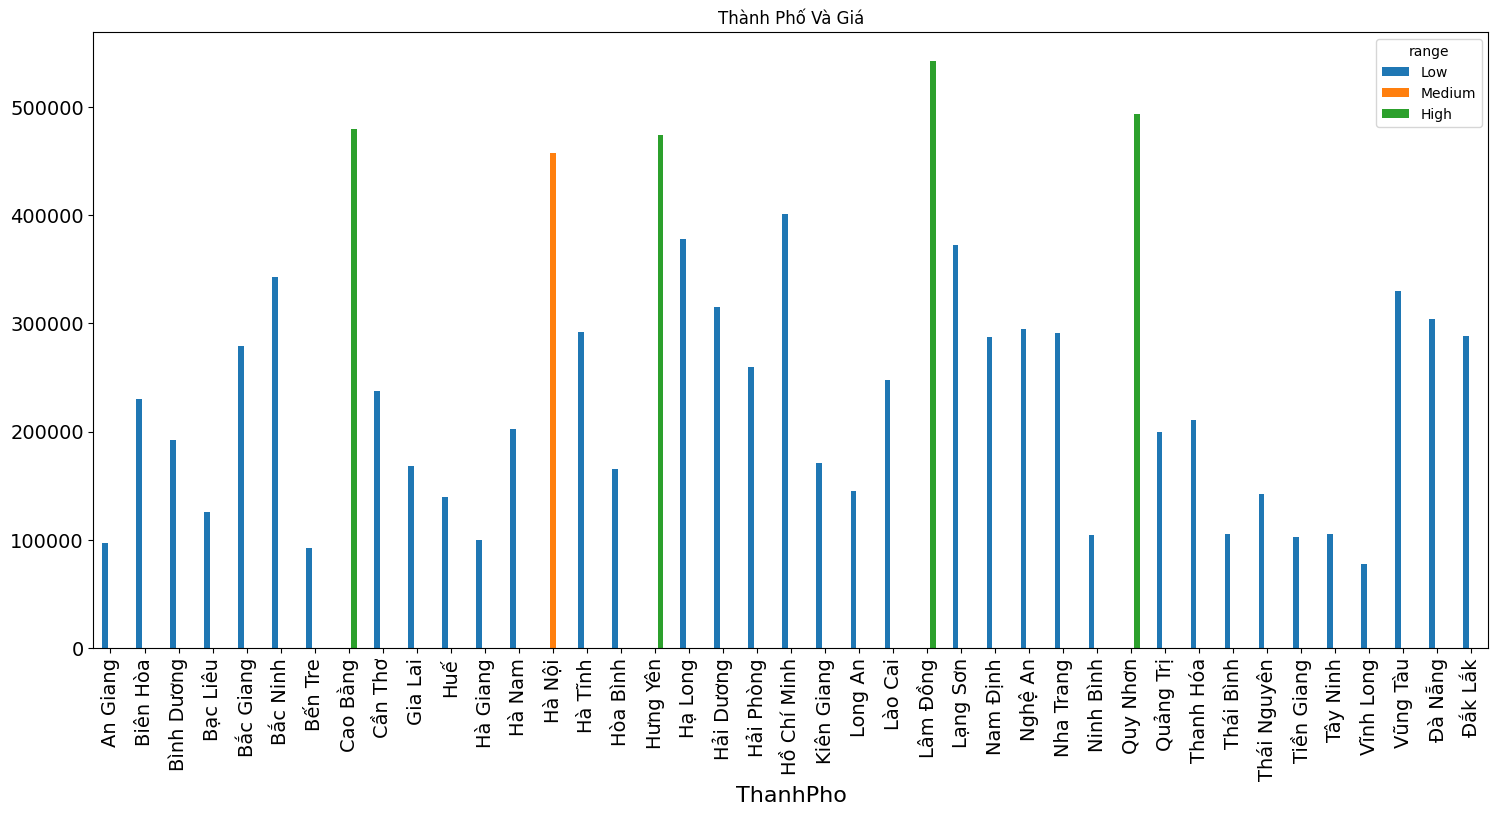

In [18]:
frame1 = df_raw

table = frame1.groupby(['ThanhPho'])['USD'].mean().reset_index()
# Gộp bảng tính giá trị trung bình vào 'frame1'
frame1 = frame1.merge(table, how='left', on='ThanhPho', suffixes=('', '_mean'))

# Chỉ định nhãn cho 3 nhóm 'Low', 'Medium', 'High'
labels = ['Low', 'Medium', 'High']

# Tạo các nhóm giá trị USD với qcut
num_bins = 3  # Số lượng nhóm bạn muốn chia
frame1['range'] = pd.qcut(frame1['USD_mean'], q=num_bins, labels=labels, duplicates='drop')

# Thiết lập kích thước hình vẽ
plt.rcParams['figure.figsize'] = (18, 8)

# Tạo DataFrame để vẽ biểu đồ
df_plot = frame1.groupby(['ThanhPho', 'range'], observed=False)['USD'].mean().unstack(fill_value=0)
df_plot.plot(kind='bar')

# Thiết lập tiêu đề cho biểu đồ
plt.title('Thành Phố Và Giá')
plt.show()

In [ ]:
# df_raw = df_raw.drop(columns=['ThanhPho','DiaChi'])

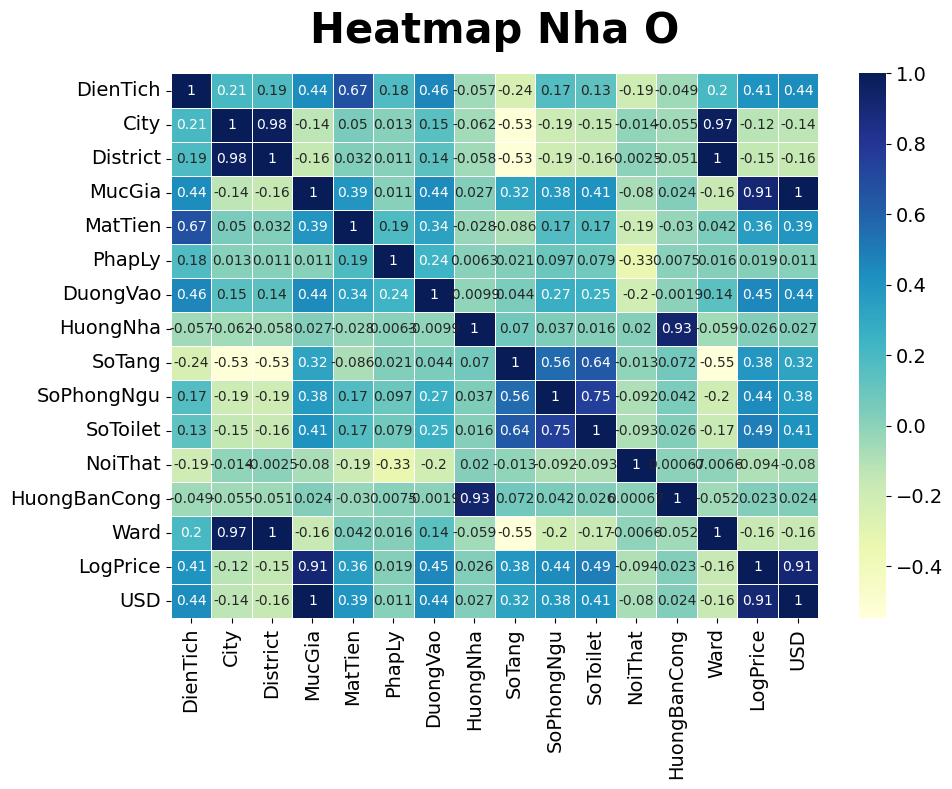

In [23]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_raw.corr(), annot = True, cmap='YlGnBu', linewidth=.5)
fig.suptitle('Heatmap Nha O',fontsize=30, fontweight="bold")
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

In [25]:
df_raw.isna().sum()

DienTich          0
City              0
District          0
MucGia            0
MatTien           0
PhapLy          159
DuongVao          0
HuongNha         19
SoTang            0
SoPhongNgu        0
SoToilet          0
NoiThat         660
HuongBanCong      0
Ward              0
LogPrice          0
USD               0
dtype: int64

In [26]:
## Tìm những trường dữ liệu có giá trị NaN
nan_values = df_raw.isna()
nan_columns = nan_values.any()
columns_with_nan = df_raw.columns[nan_columns].tolist()
columns_with_nan

['PhapLy', 'HuongNha', 'NoiThat']

In [27]:
## Tỉ lệ NaN của các trường dữ liệu
df_raw.isna().sum()/df_raw.shape[0]*100

DienTich         0.000000
City             0.000000
District         0.000000
MucGia           0.000000
MatTien          0.000000
PhapLy           5.170732
DuongVao         0.000000
HuongNha         0.617886
SoTang           0.000000
SoPhongNgu       0.000000
SoToilet         0.000000
NoiThat         21.463415
HuongBanCong     0.000000
Ward             0.000000
LogPrice         0.000000
USD              0.000000
dtype: float64

In [28]:
per = 0.5 # Chọn xóa những cột dữ liệu có trên 50% data là NaN

In [29]:
df_dropped = df_raw.dropna(axis=1,thresh=int(df_raw.shape[0]*per))
df_dropped_2 = df_dropped.dropna(how='any')
df_dropped_2

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,HuongBanCong,Ward,LogPrice,USD
8,117.9,92.0,916.0,6.400000e+09,6.84,1.0,20.0,6.0,1.0,2.0,1.0,2.0,6.0,31150.0,22.579564,256000.0
35,45.0,1.0,4.0,8.900000e+09,4.00,1.0,3.0,3.0,6.0,3.0,4.0,2.0,3.0,133.0,22.909317,356000.0
89,95.0,48.0,494.0,5.700000e+09,5.00,1.0,7.5,5.0,2.0,2.0,2.0,2.0,5.0,20285.0,22.463732,228000.0
90,112.2,74.0,724.0,2.590000e+09,5.00,1.0,4.0,1.0,1.0,4.0,2.0,2.0,1.0,25951.0,21.674924,103600.0
93,91.3,74.0,724.0,3.750000e+09,4.00,1.0,5.0,8.0,2.0,3.0,2.0,2.0,8.0,25957.0,22.045022,150000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45793,129.0,79.0,763.0,7.000000e+09,6.00,1.0,7.0,7.0,2.0,3.0,2.0,2.0,2.0,26845.0,22.669176,280000.0
45810,84.0,79.0,785.0,6.500000e+09,6.00,1.0,7.0,1.0,3.0,3.0,4.0,2.0,1.0,27622.0,22.595068,260000.0
45840,65.8,1.0,273.0,4.800000e+09,4.70,1.0,3.0,7.0,4.0,6.0,4.0,3.0,6.0,9823.0,22.291882,192000.0
45854,50.0,79.0,764.0,6.500000e+09,3.50,1.0,6.0,5.0,4.0,4.0,5.0,2.0,5.0,26882.0,22.595068,260000.0


## Xây Dựng Mô Hình

In [30]:
df_dropped_2.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,HuongBanCong,Ward,LogPrice,USD
count,2361.000000,2361.000000,2361.000000,2.361000e+03,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.00000,2361.000000,2.361000e+03
mean,77.810152,45.137230,466.253706,9.250367e+09,5.031076,1.195680,8.421559,4.928420,3.532402,3.774672,3.709869,1.960610,4.904278,16849.00720,22.703528,3.700147e+05
std,38.950046,34.011311,310.336244,7.033435e+09,1.364907,0.724158,5.413618,2.172137,1.364155,1.272280,1.399192,0.953881,2.182205,10990.74351,0.698918,2.813374e+05
min,10.000000,1.000000,1.000000,3.900000e+08,1.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,19.781657,1.560000e+04
25%,48.000000,1.000000,261.000000,4.500000e+09,4.000000,1.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,9397.00000,22.227343,1.800000e+05
50%,71.000000,48.000000,497.000000,6.900000e+09,5.000000,1.000000,7.000000,5.000000,4.000000,4.000000,4.000000,2.000000,5.000000,20323.00000,22.654787,2.760000e+05
75%,100.000000,79.000000,764.000000,1.180000e+10,6.000000,1.000000,12.000000,7.000000,5.000000,4.000000,5.000000,3.000000,7.000000,26897.00000,23.191365,4.720000e+05
max,262.000000,95.000000,954.000000,4.200000e+10,9.000000,4.000000,24.000000,8.000000,8.000000,8.000000,8.000000,3.000000,8.000000,31825.00000,24.460935,1.680000e+06


In [31]:
df_dropped_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2361 entries, 8 to 45891
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DienTich      2361 non-null   float64
 1   City          2361 non-null   float64
 2   District      2361 non-null   float64
 3   MucGia        2361 non-null   float64
 4   MatTien       2361 non-null   float64
 5   PhapLy        2361 non-null   float64
 6   DuongVao      2361 non-null   float64
 7   HuongNha      2361 non-null   float64
 8   SoTang        2361 non-null   float64
 9   SoPhongNgu    2361 non-null   float64
 10  SoToilet      2361 non-null   float64
 11  NoiThat       2361 non-null   float64
 12  HuongBanCong  2361 non-null   float64
 13  Ward          2361 non-null   float64
 14  LogPrice      2361 non-null   float64
 15  USD           2361 non-null   float64
dtypes: float64(16)
memory usage: 313.6 KB


In [32]:
X = df_dropped_2.drop(['MucGia','LogPrice','USD'], axis=1)
y = df_dropped_2['USD']

In [33]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest

In [35]:
# Khởi tạo và huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [36]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 132694.2861897047
R² Score: 0.7533740609705764


In [37]:
# Grid Search cho tối ưu hóa siêu tham số của RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearch
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán với mô hình tốt nhất
y_pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE cho mô hình RandomForest: {rmse_rf}')
print(f'R² score cho mô hình RandomForest: {r2_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\quanp\anaconda3\envs\test2\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RMSE cho mô hình RandomForest: 130180.1421290257
R² score cho mô hình RandomForest: 0.7626311151829359


## Gradient Boosting

In [38]:
# Tạo và huấn luyện mô hình Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_gb = gb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - Root Mean Squared Error: {rmse_gb}')
print(f'Gradient Boosting - R² Score: {r2_gb}')

Gradient Boosting - Root Mean Squared Error: 134480.7109102882
Gradient Boosting - R² Score: 0.746688854267832


## XGBoost

In [39]:
# Tạo và huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost - R² Score: {r2_xgb}')

XGBoost - Root Mean Squared Error: 130444.64712913813
XGBoost - R² Score: 0.7616655448490502


## LightGBM

In [40]:
# Tạo và huấn luyện mô hình LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - Root Mean Squared Error: {rmse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 1888, number of used features: 13
[LightGBM] [Info] Start training from score 374051.742982
LightGBM - Root Mean Squared Error: 121660.80468330876
LightGBM - R² Score: 0.7926826370823474


## kết hợp 3 thuật toán RR, GBR, LightGBM

In [41]:
#kết hợp 3 thuật toán RandomForestRegressor,GradientBoostingRegressor,LGBMRegressor để dự đoán
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Tạo và huấn luyện mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Stacking Regressor - Root Mean Squared Error: {rmse_stacking}')
print(f'Stacking Regressor - R² Score: {r2_stacking}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 1888, number of used features: 13
[LightGBM] [Info] Start training from score 374051.742982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 1510, number of used features: 13
[LightGBM] [Info] Start training from score 373110.528974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 1510, number of used features: 13
[LightGBM] [Info] Start